In [1]:
import numpy as np
import time
!pip3 install pyro-ppl
import pyro
import pyro.distributions as dists
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroParam

import torch
import torch.nn as nn
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro import poutine


     |████████████████████████████████| 713 kB 5.3 MB/s 


In [2]:
def get_samples():
    num_samples = 1000

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor([0., 5.])
    sig1 = torch.tensor([[2., 0.], [0., 3.]])

    mu2 = torch.tensor([5., 0.])
    sig2 = torch.tensor([[4., 0.], [0., 1.]])

    mu3 = torch.tensor([0., 10.])
    sig3 = torch.tensor([[2., 0.], [0., 3.]])

    mu4 = torch.tensor([10., 0.])
    sig4 = torch.tensor([[4., 0.], [0., 1.]])

    mu5 = torch.tensor([-5., 0.])
    sig5 = torch.tensor([[2., 0.], [0., 3.]])

    # generate samples
    dist1 = dists.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

    dist2 = dists.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]

    dist3 = dists.MultivariateNormal(mu3, sig3)
    samples3 = [pyro.sample('samples3', dist3) for _ in range(num_samples)]

    dist4 = dists.MultivariateNormal(mu4, sig4)
    samples4 = [pyro.sample('samples4', dist4) for _ in range(num_samples)]

    dist5 = dists.MultivariateNormal(mu5, sig5)
    samples5 = [pyro.sample('samples5', dist5) for _ in range(num_samples)]


    data = torch.cat((torch.stack(samples1), torch.stack(samples2), 
                      torch.stack(samples3), torch.stack(samples4),
                      torch.stack(samples5)))
    return data


K = 5
data = get_samples()

data = torch.utils.data.DataLoader(dataset = data, batch_size = 100, shuffle = True)


In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, z_dim)
        self.fc32 = nn.Linear(hidden_dim, z_dim)
        self.fc33 = nn.Linear(hidden_dim, z_dim)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.pooling1 = nn.AdaptiveMaxPool1d(2)
        self.pooling2 = nn.AdaptiveMaxPool1d(4)
        self.pooling3 = nn.AdaptiveMaxPool1d(5)
        self.pooling4 = nn.AdaptiveMaxPool1d(1)
        self.sigmoid = nn.Sigmoid()
      
    def forward(self, x):
        x = x.unsqueeze(0)
        hidden1 = self.relu(self.fc1(x))
        hidden2 = self.softplus(self.fc2(hidden1))

        z_loc = self.fc31(hidden2)
        z_loc = self.pooling1(z_loc.permute(0,2,1)).squeeze(0)
        
        z_scale = torch.exp(self.fc32(hidden2))
        z_scale = self.pooling2(z_scale.permute(0,2,1)).reshape((5, 2, 2))

        weights = self.sigmoid(self.fc33(hidden2))
        # weights = (self.pooling3(self.pooling3(weights).permute(0, 2, 1))[0]).squeeze(0).squeeze(0)
        weights = (self.pooling4(self.pooling3(weights).permute(0, 2, 1))).squeeze(0).reshape(1, 5)
        return z_loc, z_scale, weights



In [6]:
class VAEGMM(nn.Module):
  def __init__(self, input_dim = 2, z_dim = K, hidden_dim = 120, use_cuda = True):
        super().__init__()
        self.encoder = Encoder(input_dim, z_dim, hidden_dim)
        self.use_cuda = use_cuda
        self.z_dim = z_dim

  
  @config_enumerate(default='parallel')
  @poutine.broadcast
  def model(self, x):
      # z_scale = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]],
      #                                              [[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]],
      #                                              [[1., 0.], [0., 2.]]]), constraint=dists.constraints.positive)                           
      z_loc = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.],[1., 2.], [3., 4.], [1., 2.]]))

      z_loc =  pyro.param("locs", torch.tensor([[1.0, 2.0], [3.0, 4.0], [1.0, 2.0], [3.0, 4.0], [1.0, 2.0]]))
      z_scale = pyro.param("scales", torch.ones(5, 2, dtype=x.dtype, device=x.device))
    
      weights = pyro.param('weights', dists.Dirichlet(torch.ones(5) / 5), constraint=dists.constraints.unit_interval)


      with pyro.iarange('data', x.size(0)):
        assignment = torch.argmax(pyro.sample('assignment', dists.OneHotCategorical(weights))).to(torch.int64)
        # pyro.sample('obs', dists.MultivariateNormal(z_loc[assignment], z_scale[assignment]), obs=x)
        pyro.sample('obs', dists.Normal(z_loc[assignment], z_scale[assignment]).to_event(1), obs=x)

  @config_enumerate(default="parallel")
  @poutine.broadcast
  def guide(self, x):
      pyro.module("encoder",  self.encoder)
      with pyro.iarange("data", x.shape[0]):
        z_loc, z_scale, weights = self.encoder(x)
        torch.argmax(pyro.sample("assignment", dists.OneHotCategorical(weights), infer={"enumerate": "sequential"}))
        
      




In [7]:
pyro.clear_param_store()
vae = VAEGMM()
optimizer = Adam({"lr": 1.0e-3, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(vae.model, vae.guide, optimizer, loss = elbo)

n_steps = 2501
start = time.time()
elbos = []
for i in range(n_steps):
  print(i)
  elbo = 0
  for x in data:
        elbo += svi.step(x)
  elbos.append(elbo/len(data.dataset))
  if i % 500 == 0:
      z_loc = pyro.param('locs')
      z_scale = pyro.param('scales')
      weights = pyro.param('weights')

      print("locs: {}".format(z_loc))
      print("scales: {}".format(z_scale))
      print('weights = {}'.format(weights))


0
locs: tensor([[1.0208, 2.0220],
        [2.9779, 3.9727],
        [1.0364, 2.0359],
        [2.9472, 3.9439],
        [1.0235, 2.0242]], requires_grad=True)
scales: tensor([[1.0249, 1.0247],
        [1.0261, 1.0265],
        [1.0407, 1.0402],
        [1.0584, 1.0589],
        [1.0277, 1.0274]], requires_grad=True)
weights = tensor([1.3840e-06, 3.0871e-04, 1.8711e-02, 9.7957e-01, 1.4981e-03],
       grad_fn=<ClampBackward1>)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
17

[26.695872893333433, 22.729129143810272, 20.881426790890096, 19.462976139321924, 18.285869395543262, 17.270916294996532, 16.378912567906827, 15.583392878318625, 14.867437863766682, 14.218847201357164, 13.62786794892596, 13.087820566447538, 12.592249513985024, 12.136660384880233, 11.716698602246238, 11.329167534079712, 10.970668212266391, 10.63973668130958, 10.333081492566862, 10.047985535558237, 9.783131858240758, 9.53722845104436, 9.30812634874204, 9.094682645384271, 8.895696853771351, 8.710537564706945, 8.53737582154906, 8.375862325007766, 8.224561377587017, 8.083073097409654, 7.950691833388765, 7.826855512986489, 7.710574469885286, 7.601444232870481, 7.499280216742639, 7.4033161077904746, 7.3130122572417635, 7.22823194254949, 7.148799383134083, 7.074180642308342, 7.003896850411629, 6.9376843558848895, 6.875582728921104, 6.816977991999491, 6.761919390878235, 6.710347267658691, 6.661718423884237, 6.615814871048208, 6.572587477028504, 6.531939618479195, 6.493663299274416, 6.45771977379

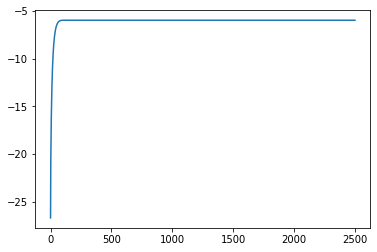

In [10]:
print(elbos)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(-np.array(elbos))

In [ ]:
import matplotlib.pyplot as plt

def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    fig.savefig(figname)


true_colors = [0] * 1000 + [1] * 1000 + [2] * 1000 + [3] * 1000 + [4] * 1000
plot(data, colors=true_colors, figname='pyro_init.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch

from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints


@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):
    # Global variables.
    weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]]), constraint=constraints.positive)
    locs = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.]]))

    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)


@config_enumerate(default="parallel")
@poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={"enumerate": "sequential"})


def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*4), constraint=constraints.positive)

    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi


def get_samples():
    num_samples = 100

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor([0., 5.])
    sig1 = torch.tensor([[2., 0.], [0., 3.]])

    mu2 = torch.tensor([5., 0.])
    sig2 = torch.tensor([[4., 0.], [0., 1.]])

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2)))
    return data


def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    fig.savefig(figname)


if __name__ == "__main__":
    pyro.enable_validation(True)
    pyro.set_rng_seed(42)

    # Create our model with a fixed number of components
    K = 2

    data = get_samples()

    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
    global_guide = config_enumerate(global_guide, 'parallel')
    _, svi = initialize(data)

    true_colors = [0] * 100 + [1] * 100
    plot(data, colors=true_colors, figname='pyro_init.png')

    for i in range(151):
        svi.step(data)

        if i == 150:
            locs = pyro.param('locs')
            scales = pyro.param('scales')
            weights = pyro.param('weights')
            assignment_probs = pyro.param('assignment_probs')

            print("locs: {}".format(locs))
            print("scales: {}".format(scales))
            print('weights = {}'.format(weights))
            print('assignments: {}'.format(assignment_probs))

            # todo plot data and estimates
            assignments = np.uint8(np.round(assignment_probs.data))
            plot(data, locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))
